### **¿Qué tipos de clientes tengo?**

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


In [2]:
#El dataset no esta agrupado por clientes, sino es trasaccional, se debera realizar el agrupamiento por clientes
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Attribute Information:

-InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

-StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

-Description: Product (item) name. Nominal.

-Quantity: The quantities of each product (item) per transaction. Numeric.

-InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

-UnitPrice: Unit price. Numeric, Product price per unit in sterling.

-CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

-Country: Country name. Nominal, the name of the country where each customer resides.

### EDA 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
#Analicemos brevemente el dataset
data.shape # cantidad de fila y columnas

(541909, 8)

In [5]:
data.dtypes.value_counts()

object            4
float64           2
int64             1
datetime64[ns]    1
dtype: int64

In [6]:
# Check valores nulos
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Check for duplicate rows and delete
data.duplicated().sum()

5268

In [8]:
data = data.drop_duplicates() # valido la existencia de duplicados
data.duplicated().sum()

0

In [9]:
data.describe().T.style.set_properties(**{'background-color': 'grey','color': 'white','border-color': 'white'})

,count,mean,std,min,25%,50%,75%,max
Quantity,536641.000000,9.620029,219.130156,-80995.000000,1.000000,3.000000,10.000000,80995.000000
UnitPrice,536641.000000,4.632656,97.233118,-11062.060000,1.250000,2.080000,4.130000,38970.000000
CustomerID,401604.000000,15281.160818,1714.006089,12346.000000,13939.000000,15145.000000,16784.000000,18287.000000


In [10]:
data = data[data['CustomerID'].notnull()] # elimino los clientes que no se pueden identificar (los que tienen valores nulos)

In [11]:
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
data['CustomerID'].nunique() # Cantidad de clientes

4372

In [13]:
#Valores unicos de cada columna
for i in list(data.columns):
    
    # get a list of unique values
    
    n = data[i].unique()
    print(i)
    print(n)
    print('\n')
   

InvoiceNo
[536365 536366 536367 ... 581585 581586 581587]


StockCode
['85123A' 71053 '84406B' ... '90214Z' 90089 23843]


Description
['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'PINK CRYSTAL SKULL PHONE CHARM'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']


Quantity
[     6      8      2     32      3      4     24     12     48     18
     20     36     80     64     10    120     96     23      5      1
     -1     50     40    100    192    432    144    288    -12    -24
     16      9    128     25     30     28      7     72    200    600
    480     -6     14     -2     -4     -5     -7     -3     11     70
    252     60    216    384     27    108     52  -9360     75    270
     42    240     90    320     17   1824    204     69    -36   -192
   -144    160   2880   1400     19     39    -48    -50     56     13
   1440     -8     15    720    -20    156    324     41    -10    -72
    -11    402 

### Análisis de variables 

In [14]:
#Separo variables numéricas y categóricas
cols_num = [x for x in data.columns if data[x].dtype != 'object' and data[x].dtype != 'bool']
cols_cat = [x for x in data.columns if x not in cols_num]
cols_cat

['InvoiceNo', 'StockCode', 'Description', 'Country']

### 'InvoiceNo'


In [15]:
data['InvoiceNo'].nunique()

22190

**Crear una variable "Cancelado" para identificar las facturas que fueron canceladas de las que no**

In [16]:
data['InvoiceNo'] = data['InvoiceNo'].astype('str')

In [17]:
data['cancelado']= data['InvoiceNo']

In [18]:
data.loc[data['cancelado'].str.contains('C'), 'cancelado'] = '1'

In [19]:
data.loc[data['cancelado'] != '1', 'cancelado'] = '0'


In [20]:
# No se Eliminarán las facturas canceladas porque contienen montos negativos por los cual compensara con las transacciones aprobadas
no_cancel = data[data['cancelado'] == '0']
cancel = data[data['cancelado'] == '1']

print ("Canceladas: %i (%.1f%%)"%(len(cancel), float(len(cancel))/len(data)*100.0))
print ("No canceladas: %i (%.1f%%)"%(len(no_cancel), float(len(no_cancel))/len(data)*100.0))
print ("Total: %i"%len(data))

Canceladas: 8872 (2.2%)
No canceladas: 392732 (97.8%)
Total: 401604


**Validar que la variable 'Quantity' < 0 son correspondientes a las facturas canceladas, es decir a las InvoiceNo que contienen la C**

In [21]:
(data['Quantity'] < 0).value_counts()


False    392732
True       8872
Name: Quantity, dtype: int64

## 'StockCode' 


In [22]:
data['StockCode'].nunique() # códigos únicos

3684

In [23]:
stock = data[data.StockCode.str.contains('[A-Z]', na=False)] # analizo la cantidad de códigos que no son numéricos para ver si tiene sentido transformarla
stock['StockCode'].nunique()

886

## 'Description'

In [24]:
data['Description'].nunique()

3896

In [25]:
data['StockCode'].nunique() # **Hay 212 descripciones distintas respecto al 'StockCode'**

3684

## Country

In [26]:
data['Country'].nunique()

37

In [27]:
data['Country'].value_counts() #cantidad de trx por país
# 241 transacciones que no tienen asociado país 


United Kingdom          356728
Germany                   9480
France                    8475
EIRE                      7475
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1471
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

# ¿Cuántos Clientes hay por país?

In [28]:
d2=data[['Country', 'CustomerID']].groupby(['Country'], as_index=False).nunique().sort_values(by='CustomerID', ascending=False)
d2
#"4 CustomerID que no tienen Pais definido 'Unspecified'"

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


<AxesSubplot:xlabel='CustomerID', ylabel='Country'>

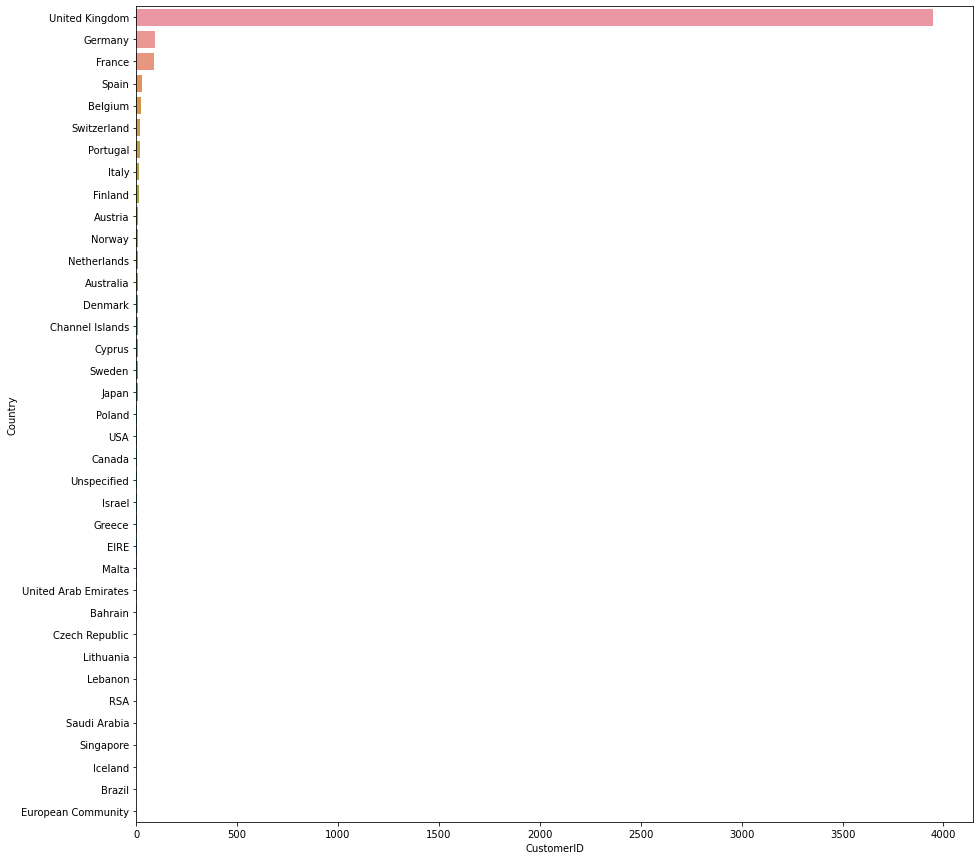

In [29]:
plt.figure(figsize = (15, 15))
sns.barplot(x="CustomerID", y="Country", data=d2)

# ¿Qué Paises venden más productos?

In [30]:
d2=data[['Country', 'Quantity']].groupby(['Country'], as_index=False).sum().sort_values(by='Quantity', ascending=False)
d2

,Country,Quantity
35,United Kingdom,3994870
23,Netherlands,200128
10,EIRE,136187
14,Germany,117341
13,France,109806
0,Australia,83643
31,Sweden,35632
32,Switzerland,29778
30,Spain,26817
19,Japan,25218


<AxesSubplot:xlabel='Quantity', ylabel='Country'>

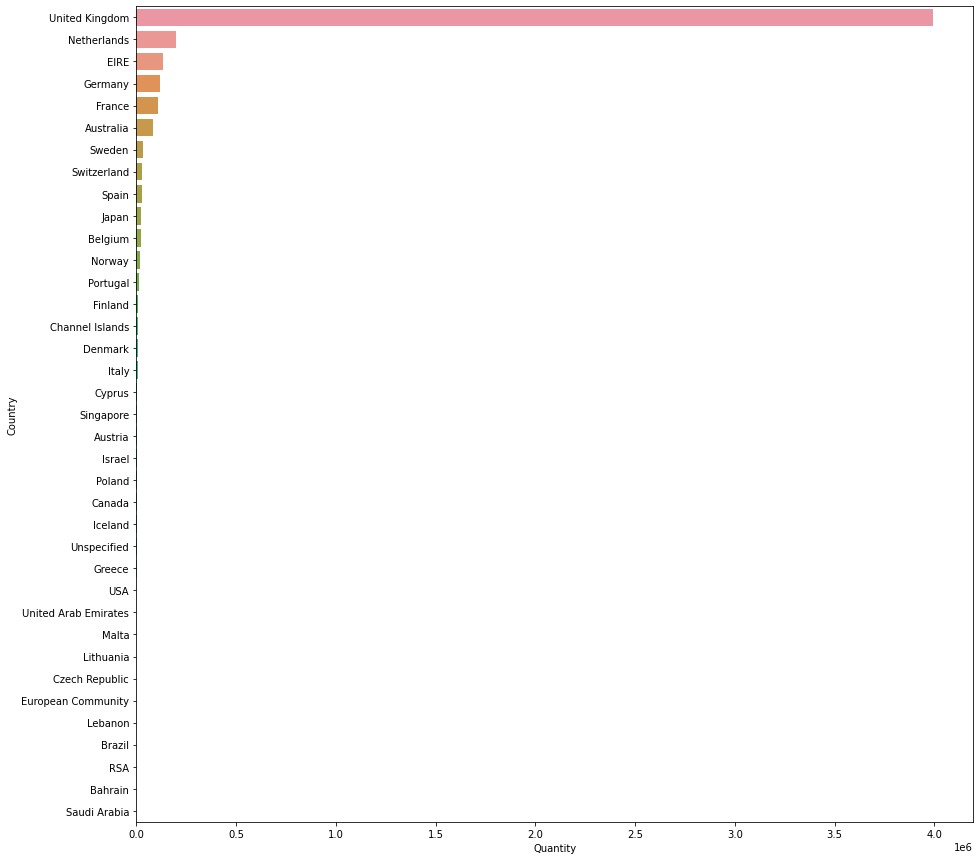

In [31]:
plt.figure(figsize = (15, 15))
sns.barplot(x="Quantity", y="Country", data=d2)

# Montos por país

In [32]:
d2=data[['Country', 'UnitPrice']].groupby(['Country'], as_index=False).sum().sort_values(by='UnitPrice', ascending=False)
d2

,Country,UnitPrice
35,United Kingdom,1165878.034
13,France,42825.230
10,EIRE,38209.260
14,Germany,37633.440
29,Singapore,25108.890
26,Portugal,12903.250
30,Spain,12621.500
3,Belgium,7540.130
32,Switzerland,6568.600
24,Norway,6529.060


<AxesSubplot:xlabel='UnitPrice', ylabel='Country'>

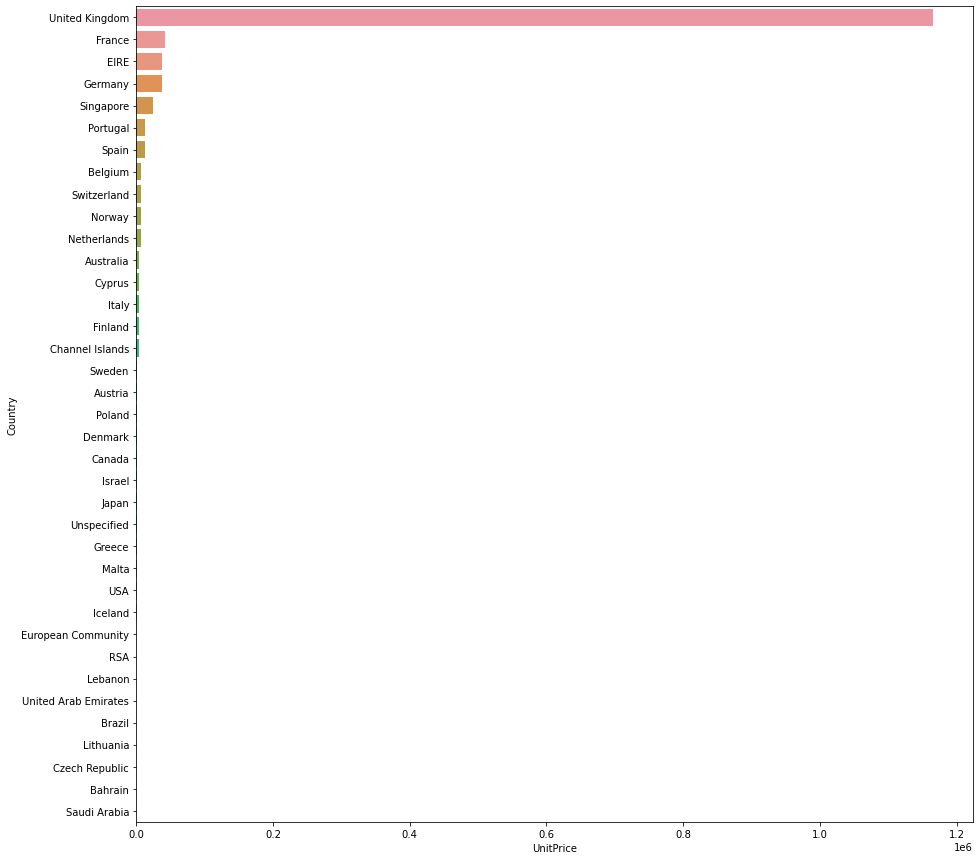

In [33]:
plt.figure(figsize = (15, 15))
sns.barplot(x="UnitPrice", y="Country", data=d2)

## UnitPrice	
### Creación de una nueva variable 'QxPrice', cantidad por precio

In [34]:

data['QxPrice'] =data['Quantity']* data['UnitPrice']


In [35]:
d2=data[['Country', 'QxPrice']].groupby(['Country'], as_index=False).sum().sort_values(by='QxPrice', ascending=False)
d2

,Country,QxPrice
35,United Kingdom,6747156.154
23,Netherlands,284661.540
10,EIRE,250001.780
14,Germany,221509.470
13,France,196626.050
0,Australia,137009.770
32,Switzerland,55739.400
30,Spain,54756.030
3,Belgium,40910.960
31,Sweden,36585.410


<AxesSubplot:xlabel='QxPrice', ylabel='Country'>

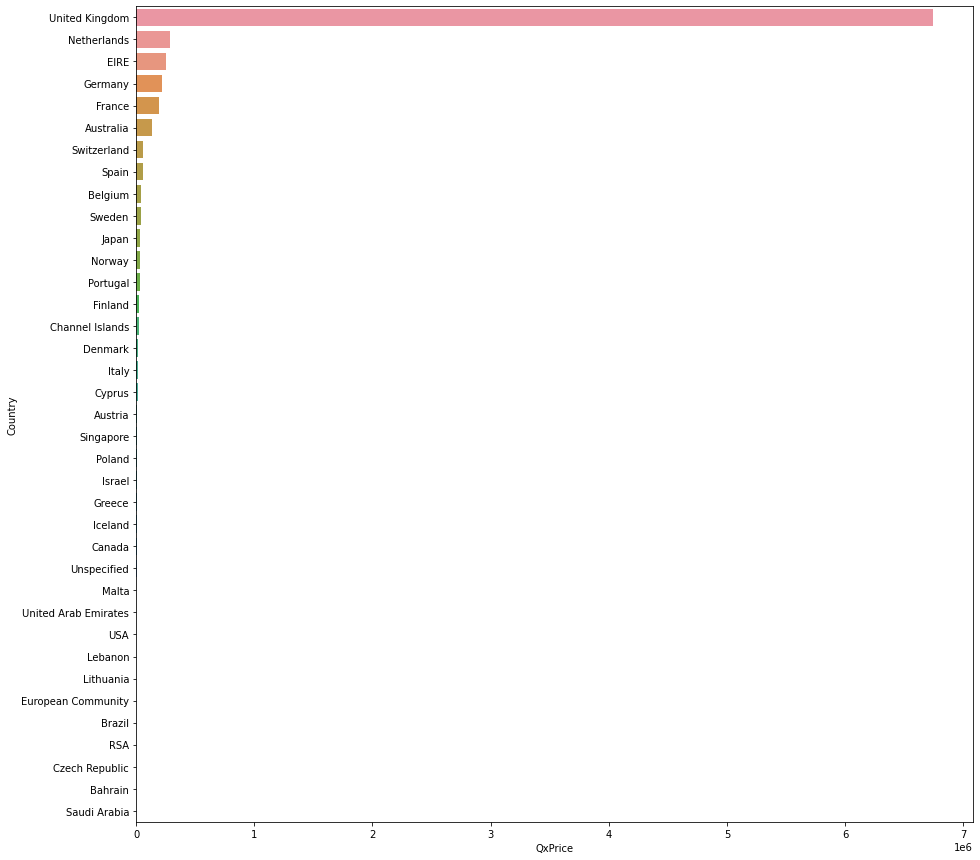

In [36]:
plt.figure(figsize = (15, 15))
sns.barplot(x="QxPrice", y="Country", data=d2)

In [37]:
d2=data[['cancelado', 'QxPrice']].groupby(['cancelado'], as_index=False).sum().sort_values(by='QxPrice', ascending=False)
d2

,cancelado,QxPrice
0,0,8887208.894
1,1,-608689.470


<AxesSubplot:xlabel='cancelado', ylabel='QxPrice'>

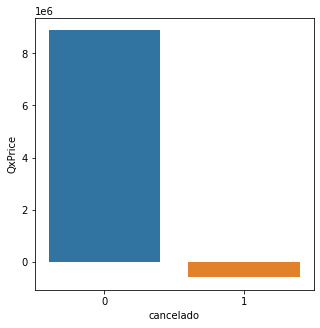

In [38]:
plt.figure(figsize = (5, 5))
sns.barplot(y="QxPrice", x="cancelado", data=d2)

## 'Quantity'

In [39]:
data['Quantity'].nunique()

436

In [40]:
data['Quantity'].value_counts()

 1        69605
 12       59828
 2        57425
 6        37480
 4        32093
          ...  
 828          1
 560          1
-408          1
 512          1
-80995        1
Name: Quantity, Length: 436, dtype: int64

In [41]:
data['Quantity'].describe()

count    401604.000000
mean         12.183273
std         250.283037
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [42]:
Q = pd.DataFrame (data.loc[data['Quantity'] > 0, 'Quantity'])

In [43]:
Q.describe()

,Quantity
count,392732.000000
mean,13.153718
std,181.588420
min,1.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,80995.000000


In [44]:
QNeg = pd.DataFrame (data.loc[data['Quantity'] < 0, 'Quantity'])
QNeg.describe()

,Quantity
count,8872.000000
mean,-30.774910
std,1172.249902
min,-80995.000000
25%,-6.000000
50%,-2.000000
75%,-1.000000
max,-1.000000


In [45]:
data[data['UnitPrice'] == 0].shape          

(40, 10)

## Transformar la variable Country por la cantidad de CustomerID


In [46]:

data['Country']= data.groupby('Country')['CustomerID'].transform('nunique')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelado,QxPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,3950,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,3950,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,3950,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,3950,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,3950,0,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,87,0,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,87,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,87,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,87,0,16.60


# Crear nuevo dataframe  Customer 

### Cantidad de compras

In [47]:
# Arrancamos con la variable Cantidad_compras
cantidad_compras= data.groupby('CustomerID', as_index=False)['InvoiceNo'].nunique()
cantidad_compras.rename(columns={'InvoiceNo':'cantidad_compras'}, inplace=True) #Renombrar la Variable InvoiceNo por Cantidad Compras
cantidad_compras.sort_values(by='cantidad_compras', ascending=False)

,CustomerID,cantidad_compras
1895,14911.0,248
330,12748.0,224
4042,17841.0,169
1674,14606.0,128
568,13089.0,118
...,...,...
1141,13877.0,1
2997,16400.0,1
1142,13878.0,1
1149,13886.0,1


Se podría generar una nueva variable 
##mejor_producto= data.groupby('CustomerID', as_index=False)['StockCode'].nunique()
##mejor_producto.sort_values(by='StockCode', ascending=False)

### Cantidad de Productos

In [48]:
cantidad_productos= data.groupby('CustomerID', as_index=False)['Quantity'].sum()
cantidad_productos.rename(columns={'Quantity':'cantidad_productos'}, inplace=True)
cantidad_productos.sort_values(by='cantidad_productos', ascending=False)

,CustomerID,cantidad_productos
1703,14646.0,196719
55,12415.0,77242
1895,14911.0,77155
3758,17450.0,69009
4233,18102.0,64122
...,...,...
2892,16252.0,-158
3245,16742.0,-189
1384,14213.0,-244
2578,15823.0,-283


### Merge de las variables 'cantidad_compras' y 'cantidad_productos'

In [49]:
customer = cantidad_compras.merge(cantidad_productos, how='inner', left_on='CustomerID',right_on = 'CustomerID')
customer

,CustomerID,cantidad_compras,cantidad_productos
0,12346.0,2,0
1,12347.0,7,2458
2,12348.0,4,2341
3,12349.0,1,631
4,12350.0,1,197
...,...,...,...
4367,18280.0,1,45
4368,18281.0,1,54
4369,18282.0,3,98
4370,18283.0,16,1357


### 'total_facturado'

In [50]:
total_facturado= data.groupby('CustomerID', as_index=False)['QxPrice'].sum()
total_facturado.rename(columns={'QxPrice':'total_facturado'}, inplace=True)
total_facturado.sort_values(by='total_facturado', ascending=False)

,CustomerID,total_facturado
1703,14646.0,279489.02
4233,18102.0,256438.49
3758,17450.0,187322.17
1895,14911.0,132458.73
55,12415.0,123725.45
...,...,...
125,12503.0,-1126.00
3870,17603.0,-1165.30
1384,14213.0,-1192.20
2236,15369.0,-1592.49


### Merge con la variable 'total_facturado'

In [51]:
customer = customer.merge(total_facturado, how='inner', left_on='CustomerID',right_on = 'CustomerID')
customer

,CustomerID,cantidad_compras,cantidad_productos,total_facturado
0,12346.0,2,0,0.00
1,12347.0,7,2458,4310.00
2,12348.0,4,2341,1797.24
3,12349.0,1,631,1757.55
4,12350.0,1,197,334.40
...,...,...,...,...
4367,18280.0,1,45,180.60
4368,18281.0,1,54,80.82
4369,18282.0,3,98,176.60
4370,18283.0,16,1357,2045.53


### 'primera_compra'

In [52]:
data['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [53]:
primera_compra= data.groupby('CustomerID', as_index=False)['InvoiceDate'].min()
primera_compra.rename(columns={'InvoiceDate':'primera_compra'}, inplace=True)
primera_compra.sort_values(by='primera_compra', ascending=True)

,CustomerID,primera_compra
4048,17850.0,2010-12-01 08:26:00
540,13047.0,2010-12-01 08:34:00
191,12583.0,2010-12-01 08:45:00
1047,13748.0,2010-12-01 09:00:00
2029,15100.0,2010-12-01 09:09:00
...,...,...
823,13436.0,2011-12-08 10:33:00
2346,15520.0,2011-12-08 10:58:00
723,13298.0,2011-12-08 13:11:00
1649,14569.0,2011-12-08 14:58:00


### Merge con la variable 'primera_compra'

In [54]:
customer = customer.merge(primera_compra, how='inner', left_on='CustomerID',right_on = 'CustomerID')
customer

,CustomerID,cantidad_compras,cantidad_productos,total_facturado,primera_compra
0,12346.0,2,0,0.00,2011-01-18 10:01:00
1,12347.0,7,2458,4310.00,2010-12-07 14:57:00
2,12348.0,4,2341,1797.24,2010-12-16 19:09:00
3,12349.0,1,631,1757.55,2011-11-21 09:51:00
4,12350.0,1,197,334.40,2011-02-02 16:01:00
...,...,...,...,...,...
4367,18280.0,1,45,180.60,2011-03-07 09:52:00
4368,18281.0,1,54,80.82,2011-06-12 10:53:00
4369,18282.0,3,98,176.60,2011-08-05 13:35:00
4370,18283.0,16,1357,2045.53,2011-01-06 14:14:00


### ultima_compra

In [55]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [56]:
ultima_compra= data.groupby('CustomerID', as_index=False)['InvoiceDate'].max()
ultima_compra.rename(columns={'InvoiceDate':'ultima_compra'}, inplace=True)
ultima_compra.sort_values(by='ultima_compra', ascending=False)

,CustomerID,ultima_compra
275,12680.0,2011-12-09 12:50:00
587,13113.0,2011-12-09 12:49:00
2562,15804.0,2011-12-09 12:31:00
1067,13777.0,2011-12-09 12:25:00
3854,17581.0,2011-12-09 12:21:00
...,...,...
3129,16583.0,2010-12-01 12:03:00
4096,17908.0,2010-12-01 11:45:00
359,12791.0,2010-12-01 11:27:00
1046,13747.0,2010-12-01 10:37:00


### Merge con la variable 'ultima_compra'

In [57]:
customer = customer.merge(ultima_compra, how='inner', left_on='CustomerID',right_on = 'CustomerID')
customer

,CustomerID,cantidad_compras,cantidad_productos,total_facturado,primera_compra,ultima_compra
0,12346.0,2,0,0.00,2011-01-18 10:01:00,2011-01-18 10:17:00
1,12347.0,7,2458,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00
2,12348.0,4,2341,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00
3,12349.0,1,631,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00
4,12350.0,1,197,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00
...,...,...,...,...,...,...
4367,18280.0,1,45,180.60,2011-03-07 09:52:00,2011-03-07 09:52:00
4368,18281.0,1,54,80.82,2011-06-12 10:53:00,2011-06-12 10:53:00
4369,18282.0,3,98,176.60,2011-08-05 13:35:00,2011-12-02 11:43:00
4370,18283.0,16,1357,2045.53,2011-01-06 14:14:00,2011-12-06 12:02:00


### País - Los clientes que poseen más de un País se toma como País el valor más frecuente

#Como se realiza el conteo de los clientes con mas de un pais???
pais = data2.groupby('CustomerID', as_index=False)['Country'].max()
pais.rename(columns={'Country':'pais'}, inplace=True)
pais.sort_values(by='pais', ascending=False).head(20)

In [58]:
fecha= data.groupby('CustomerID', as_index=False)['InvoiceDate'].max() # en base a la ultima compra
fecha_pais = fecha.merge(data, how='inner', left_on=['CustomerID','InvoiceDate'],right_on = ['CustomerID','InvoiceDate'])[['CustomerID','Country']]
fecha_pais.rename(columns={'Country':'pais'}, inplace=True)
fecha_pais

,CustomerID,pais
0,12346.0,3950
1,12347.0,1
2,12347.0,1
3,12347.0,1
4,12347.0,1
...,...,...
81275,18283.0,3950
81276,18283.0,3950
81277,18287.0,3950
81278,18287.0,3950


In [59]:
pais= fecha_pais.groupby('CustomerID', as_index=False)['pais'].max()
pais.sort_values(by='pais', ascending=False)

,CustomerID,pais
0,12346.0,3950
2907,16274.0,3950
2913,16282.0,3950
2912,16281.0,3950
2911,16279.0,3950
...,...,...
351,12781.0,1
1,12347.0,1
176,12565.0,1
345,12769.0,1


### Merge con la variable 'pais'

In [60]:
customer = customer.merge(pais, how='inner', left_on='CustomerID',right_on = 'CustomerID')
customer

,CustomerID,cantidad_compras,cantidad_productos,total_facturado,primera_compra,ultima_compra,pais
0,12346.0,2,0,0.00,2011-01-18 10:01:00,2011-01-18 10:17:00,3950
1,12347.0,7,2458,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,1
2,12348.0,4,2341,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,12
3,12349.0,1,631,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,15
4,12350.0,1,197,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,10
...,...,...,...,...,...,...,...
4367,18280.0,1,45,180.60,2011-03-07 09:52:00,2011-03-07 09:52:00,3950
4368,18281.0,1,54,80.82,2011-06-12 10:53:00,2011-06-12 10:53:00,3950
4369,18282.0,3,98,176.60,2011-08-05 13:35:00,2011-12-02 11:43:00,3950
4370,18283.0,16,1357,2045.53,2011-01-06 14:14:00,2011-12-06 12:02:00,3950


In [61]:
customer = customer.set_index(['CustomerID'], drop=True)
customer

,cantidad_compras,cantidad_productos,total_facturado,primera_compra,ultima_compra,pais
CustomerID,,,,,,
12346.0,2,0,0.00,2011-01-18 10:01:00,2011-01-18 10:17:00,3950
12347.0,7,2458,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,1
12348.0,4,2341,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,12
12349.0,1,631,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,15
12350.0,1,197,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,10
...,...,...,...,...,...,...
18280.0,1,45,180.60,2011-03-07 09:52:00,2011-03-07 09:52:00,3950
18281.0,1,54,80.82,2011-06-12 10:53:00,2011-06-12 10:53:00,3950
18282.0,3,98,176.60,2011-08-05 13:35:00,2011-12-02 11:43:00,3950


### Convierto la variable las fechas en enteros

In [62]:
customer['primera_compra'] = pd.to_datetime(customer['primera_compra']).dt.strftime("%Y%m%d")
customer['ultima_compra'] = pd.to_datetime(customer['ultima_compra']).dt.strftime("%Y%m%d")

In [63]:
customer[['primera_compra','ultima_compra']] = customer[['primera_compra','ultima_compra']].astype(int)

In [64]:
customer

,cantidad_compras,cantidad_productos,total_facturado,primera_compra,ultima_compra,pais
CustomerID,,,,,,
12346.0,2,0,0.00,20110118,20110118,3950
12347.0,7,2458,4310.00,20101207,20111207,1
12348.0,4,2341,1797.24,20101216,20110925,12
12349.0,1,631,1757.55,20111121,20111121,15
12350.0,1,197,334.40,20110202,20110202,10
...,...,...,...,...,...,...
18280.0,1,45,180.60,20110307,20110307,3950
18281.0,1,54,80.82,20110612,20110612,3950
18282.0,3,98,176.60,20110805,20111202,3950


In [65]:
customer.to_csv("customer_fecha.csv")

# Matriz de Correlación

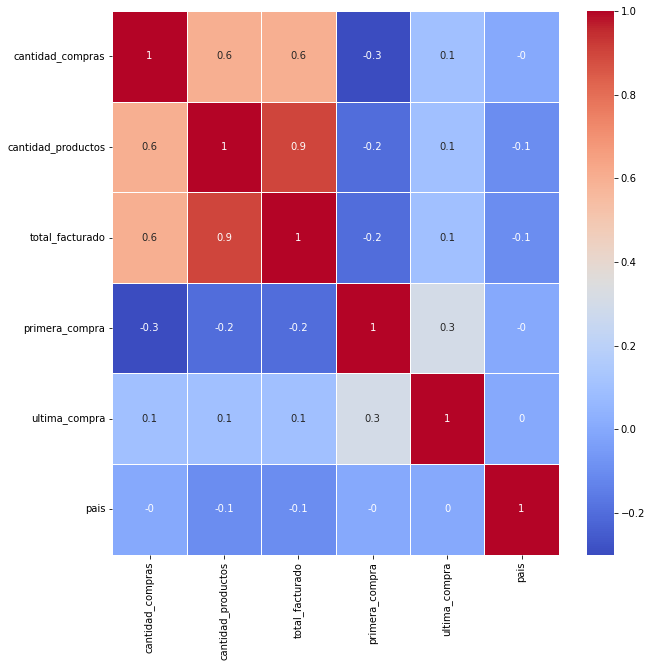

In [66]:
# Elegir las variables que tienen poca correlación entre ellas 
plt.figure(figsize=(10,10))
sns.heatmap(round(customer.corr(),1), cmap="coolwarm", annot=True, linewidths=.5)
plt.show()